
### Baseline Recommendation Models
===============================

This notebook implements and evaluates baseline recommenders:
- Random recommender
- Popularity-based recommenders
- Time-decay popularity
- Trending items

In [10]:
# ============================================================================
# 1: Imports and Setup
# ============================================================================

import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import MovieLensLoader
from src.preprocess import prepare_data_for_training
from src.recommenders.popularity import (
    RandomRecommender,
    PopularityRecommender,
    TimeDecayPopularityRecommender,
    TrendingRecommender
)
from src.evaluation import RecommenderEvaluator
from src.utils import plot_model_comparison

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")


✓ Imports successful


In [ ]:
# ============================================================================
# 2: Load and Prepare Data
# ============================================================================
print("Loading data...")
loader = MovieLensLoader()
loader.download_data()
ratings = loader.load_ratings()
movies = loader.load_movies()

# Prepare train/test split
print("\nPreparing train/test split...")
train, test, metadata = prepare_data_for_training(
    ratings,
    test_size=0.2,
    split_method='user_based',
    min_user_ratings=5,
    min_item_ratings=5,
    random_state=42
)

all_items = set(ratings['item_id'].unique())

print("\n✓ Data preparation complete")
print(f"  Train: {len(train):,} ratings")
print(f"  Test: {len(test):,} ratings")


Loading data...
Extracting dataset...
Dataset downloaded and extracted to data\raw\ml-100k
Loaded 100,000 ratings
Users: 943
Items: 1,682
Sparsity: 0.9370
Loaded 1,682 movies

Preparing train/test split...
Data Preparation Pipeline
Filtered: 100,000 -> 99,287 ratings
Users: 943
Items: 1,349
User-based split: 79,790 train, 19,497 test
All 943 users have data in both sets

Data Preparation Complete
Train ratings: 79,790
Test ratings: 19,497
Users: 943
Items: 1,682
Sparsity: 0.9370

✓ Data preparation complete
  Train: 79,790 ratings
  Test: 19,497 ratings


In [ ]:
# ============================================================================
# 3: Train Random Baseline
# ============================================================================
print("\n" + "="*70)
print("1. RANDOM RECOMMENDER (Baseline)")
print("="*70)

random_rec = RandomRecommender(random_state=42)
random_rec.fit(train)

# Test predictions
print("\nSample predictions:")
for user_id in [1, 10, 50]:
    for item_id in [1, 100, 500]:
        pred = random_rec.predict(user_id, item_id)
        print(f"  User {user_id}, Item {item_id}: {pred:.2f}")

# Generate recommendations
print("\nSample recommendations for user 1:")
recs = random_rec.recommend(user_id=1, n=10)
for i, (item_id, score) in enumerate(recs, 1):
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"  {i}. {title} (score: {score:.3f})")




1. RANDOM RECOMMENDER (Baseline)
RandomRecommender fitted with 1349 items

Sample predictions:
  User 1, Item 1: 3.78
  User 1, Item 100: 3.47
  User 1, Item 500: 3.86
  User 10, Item 1: 4.30
  User 10, Item 100: 3.42
  User 10, Item 500: 3.42
  User 50, Item 1: 4.33
  User 50, Item 100: 3.92
  User 50, Item 500: 3.30

Sample recommendations for user 1:
  1. Groundhog Day (1993) (score: 5.462)
  2. Dragonheart (1996) (score: 5.076)
  3. Empire Strikes Back, The (1980) (score: 4.896)
  4. Father of the Bride Part II (1995) (score: 4.852)
  5. Jack and Sarah (1995) (score: 4.826)
  6. Touch of Evil (1958) (score: 4.823)
  7. If Lucy Fell (1996) (score: 4.816)
  8. Postman, The (1997) (score: 4.800)
  9. Land Before Time III: The Time of the Great Giving (1995) (V) (score: 4.783)
  10. Sgt. Bilko (1996) (score: 4.768)


In [15]:
# ============================================================================
# 4: Train Popularity Recommenders
# ============================================================================
print("\n" + "="*70)
print("2. POPULARITY-BASED RECOMMENDERS")
print("="*70)

# Count-based popularity
print("\n2a. Popularity (Count-based)")
pop_count = PopularityRecommender(method='count')
pop_count.fit(train)

print("\nTop 10 most popular items:")
recs = pop_count.recommend(user_id=1, n=10, exclude_seen=False)
for i, (item_id, score) in enumerate(recs, 1):
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"  {i}. {title} (score: {score:.3f})")

# Average rating popularity
print("\n2b. Popularity (Average Rating)")
pop_avg = PopularityRecommender(method='average')
pop_avg.fit(train)

# Weighted popularity
print("\n2c. Popularity (Weighted)")
pop_weighted = PopularityRecommender(method='weighted')
pop_weighted.fit(train)




2. POPULARITY-BASED RECOMMENDERS

2a. Popularity (Count-based)
PopularityRecommender fitted with method='count'

Top 10 most popular items:
  1. Star Wars (1977) (score: 1.000)
  2. Contact (1997) (score: 0.887)
  3. Fargo (1996) (score: 0.860)
  4. English Patient, The (1996) (score: 0.828)
  5. Liar Liar (1997) (score: 0.826)
  6. Return of the Jedi (1983) (score: 0.819)
  7. Scream (1996) (score: 0.815)
  8. Toy Story (1995) (score: 0.783)
  9. Independence Day (ID4) (1996) (score: 0.770)
  10. Air Force One (1997) (score: 0.760)

2b. Popularity (Average Rating)
PopularityRecommender fitted with method='average'

2c. Popularity (Weighted)
PopularityRecommender fitted with method='weighted'


PopularityRecommender (fitted)

In [16]:
# ============================================================================
# 5: Train Time-Decay Popularity
# ============================================================================
print("\n" + "="*70)
print("3. TIME-DECAY POPULARITY RECOMMENDER")
print("="*70)

time_decay_rec = TimeDecayPopularityRecommender(decay_rate=0.95, time_unit='days')
time_decay_rec.fit(train)

print("\nTop 10 recommendations (with time decay):")
recs = time_decay_rec.recommend(user_id=1, n=10, exclude_seen=False)
for i, (item_id, score) in enumerate(recs, 1):
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"  {i}. {title} (score: {score:.3f})")



3. TIME-DECAY POPULARITY RECOMMENDER
TimeDecayPopularityRecommender fitted with decay_rate=0.95

Top 10 recommendations (with time decay):
  1. Titanic (1997) (score: 1.000)
  2. Contact (1997) (score: 0.872)
  3. Air Force One (1997) (score: 0.847)
  4. Full Monty, The (1997) (score: 0.741)
  5. Good Will Hunting (1997) (score: 0.712)
  6. Star Wars (1977) (score: 0.662)
  7. English Patient, The (1996) (score: 0.659)
  8. Liar Liar (1997) (score: 0.639)
  9. Scream (1996) (score: 0.620)
  10. As Good As It Gets (1997) (score: 0.586)


In [17]:
# ============================================================================
# 6: Train Trending Recommender
# ============================================================================
print("\n" + "="*70)
print("4. TRENDING RECOMMENDER")
print("="*70)

trending_rec = TrendingRecommender(window_days=30)
trending_rec.fit(train)

print("\nTop 10 trending items:")
recs = trending_rec.recommend(user_id=1, n=10, exclude_seen=False)
for i, (item_id, score) in enumerate(recs, 1):
    movie_title = movies[movies['item_id'] == item_id]['title'].values
    title = movie_title[0] if len(movie_title) > 0 else "Unknown"
    print(f"  {i}. {title} (score: {score:.3f})")



4. TRENDING RECOMMENDER
TrendingRecommender fitted with window_days=30
Found 1349 trending items

Top 10 trending items:
  1. As Good As It Gets (1997) (score: 1.000)
  2. Lost in Space (1998) (score: 0.807)
  3. Big Lebowski, The (1998) (score: 0.779)
  4. Good Will Hunting (1997) (score: 0.714)
  5. Apt Pupil (1998) (score: 0.681)
  6. Titanic (1997) (score: 0.677)
  7. Primary Colors (1998) (score: 0.660)
  8. Wild Things (1998) (score: 0.627)
  9. Man in the Iron Mask, The (1998) (score: 0.627)
  10. Wag the Dog (1997) (score: 0.616)


In [18]:
# ============================================================================
# 7: Evaluate All Baselines
# ============================================================================
print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION")
print("="*70)

evaluator = RecommenderEvaluator(k_values=[5, 10, 20])

models = {
    'Random': random_rec,
    'Pop-Count': pop_count,
    'Pop-Average': pop_avg,
    'Pop-Weighted': pop_weighted,
    'Time-Decay': time_decay_rec,
    'Trending': trending_rec
}

results_df = evaluator.compare_models(
    models=models,
    test_data=test,
    train_data=train,
    all_items=all_items,
    n_recommendations=10
)

print("\n" + "="*70)
print("MODEL COMPARISON RESULTS")
print("="*70)
print(results_df)



COMPREHENSIVE EVALUATION

Evaluating Random...

Evaluating Pop-Count...

Evaluating Pop-Average...

Evaluating Pop-Weighted...

Evaluating Time-Decay...

Evaluating Trending...

MODEL COMPARISON RESULTS
              Precision@5  Recall@5    F1@5  NDCG@5  HitRate@5  Precision@10  \
Random             0.0112    0.0038  0.0049  0.0119     0.0529        0.0099   
Pop-Count          0.1479    0.0883  0.0908  0.1644     0.5097        0.1282   
Pop-Average        0.0419    0.0151  0.0200  0.0332     0.1695        0.0535   
Pop-Weighted       0.1521    0.0658  0.0786  0.1718     0.4676        0.1293   
Time-Decay         0.0922    0.0666  0.0633  0.1048     0.3585        0.0952   
Trending           0.0225    0.0187  0.0161  0.0242     0.1015        0.0191   

              Recall@10   F1@10  NDCG@10  HitRate@10  Precision@20  Recall@20  \
Random           0.0075  0.0073   0.0114      0.0940        0.0050     0.0075   
Pop-Count        0.1381  0.1088   0.1685      0.6609        0.0641     0.


VISUALIZATION


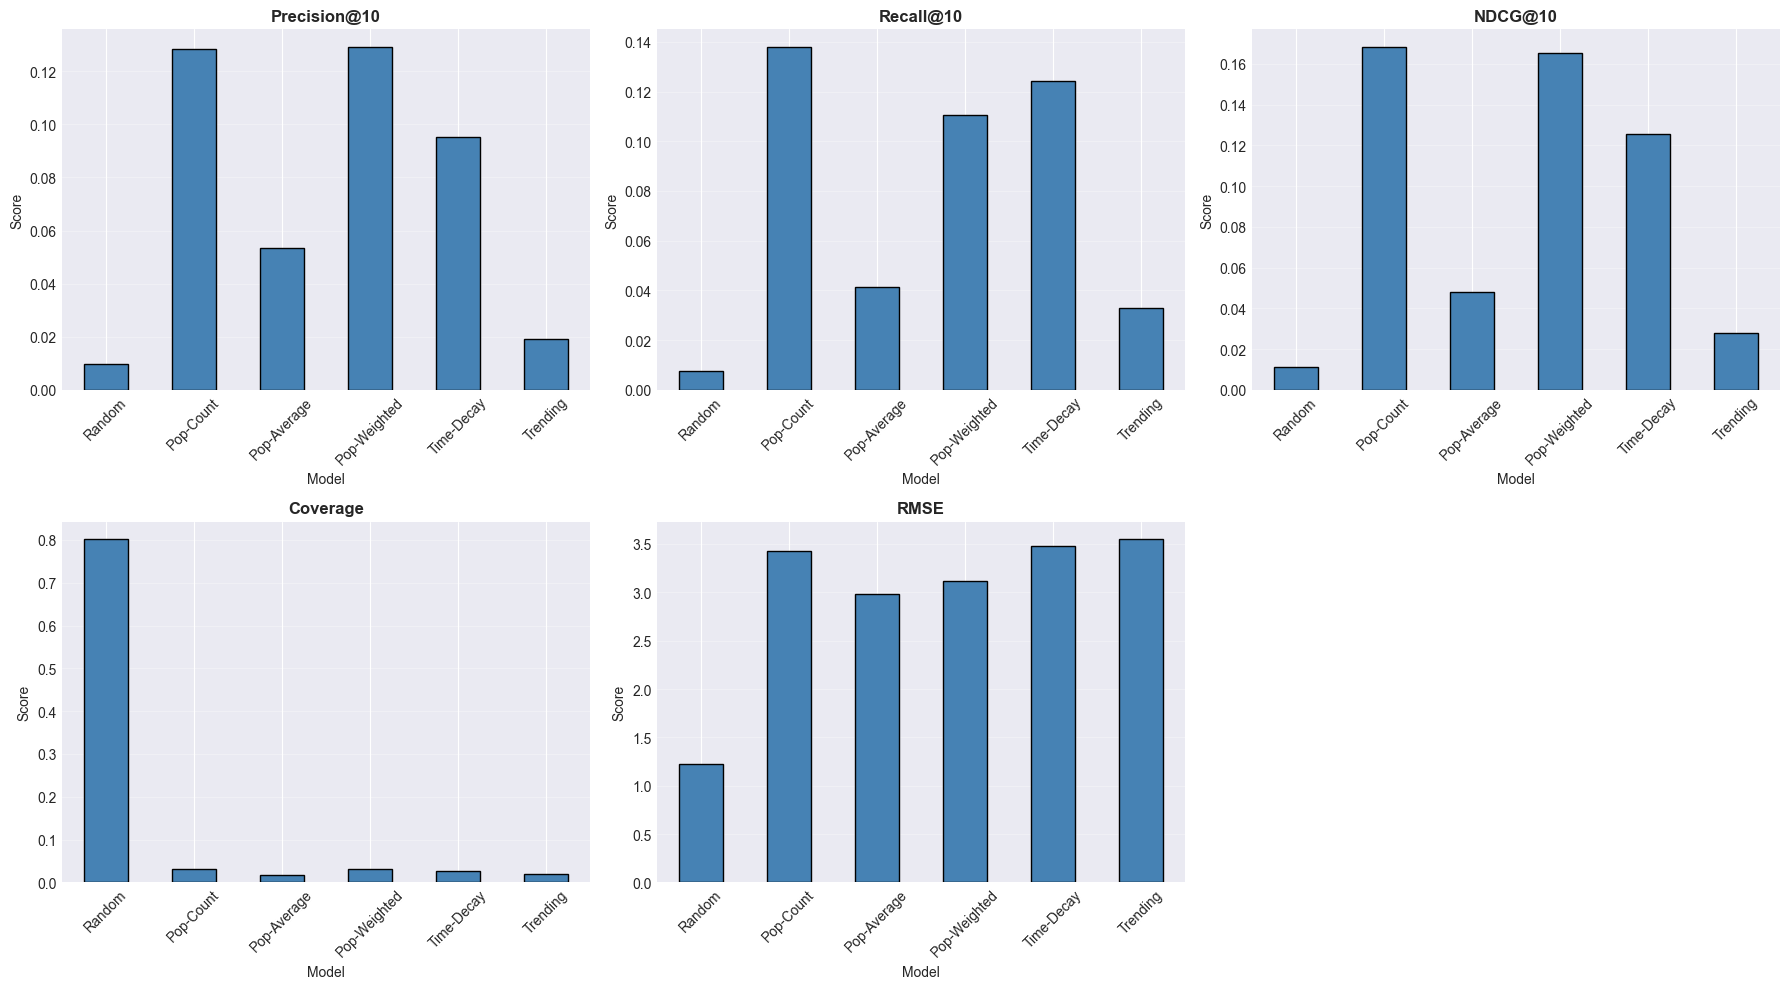

ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of labels (3).

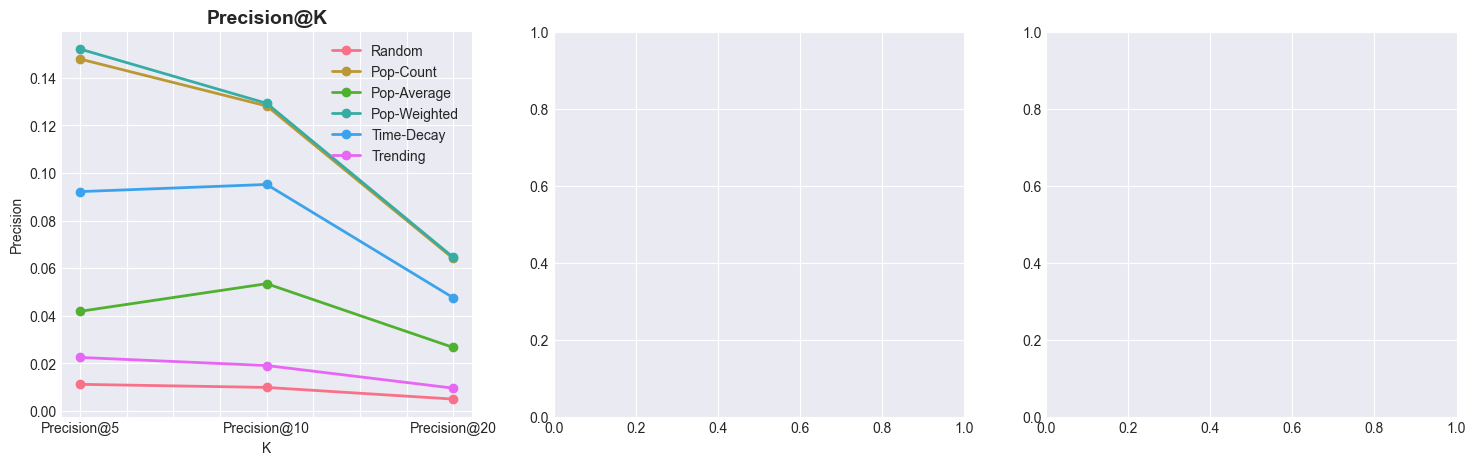

In [20]:
# ============================================================================
# Cell 8: Visualize Results
# ============================================================================
print("\n" + "="*70)
print("VISUALIZATION")
print("="*70)

# Select key metrics to plot
key_metrics = ['Precision@10', 'Recall@10', 'NDCG@10', 'Coverage', 'RMSE']
plot_model_comparison(results_df, metrics=key_metrics)

# Plot all metrics at different K values
precision_metrics = [col for col in results_df.columns if 'Precision@' in col]
recall_metrics = [col for col in results_df.columns if 'Recall@' in col]
ndcg_metrics = [col for col in results_df.columns if 'NDCG@' in col]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision@K
results_df[precision_metrics].T.plot(kind='line', ax=axes[0], marker='o', linewidth=2)
axes[0].set_title('Precision@K', fontsize=14, fontweight='bold')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Precision')
axes[0].set_xticklabels([col.split('@')[1] for col in precision_metrics])
axes[0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(alpha=0.3)

# Recall@K
results_df[recall_metrics].T.plot(kind='line', ax=axes[1], marker='o', linewidth=2)
axes[1].set_title('Recall@K', fontsize=14, fontweight='bold')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Recall')
axes[1].set_xticklabels([col.split('@')[1] for col in recall_metrics])
axes[1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(alpha=0.3)

# NDCG@K
results_df[ndcg_metrics].T.plot(kind='line', ax=axes[2], marker='o', linewidth=2)
axes[2].set_title('NDCG@K', fontsize=14, fontweight='bold')
axes[2].set_xlabel('K')
axes[2].set_ylabel('NDCG')
axes[2].set_xticklabels([col.split('@')[1] for col in ndcg_metrics])
axes[2].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()





COVERAGE AND DIVERSITY ANALYSIS

Catalog Coverage:
  Random         : 0.8020 (1349/1682 items)
  Pop-Count      : 0.0315 (53/1682 items)
  Pop-Average    : 0.0178 (30/1682 items)
  Pop-Weighted   : 0.0309 (52/1682 items)
  Time-Decay     : 0.0279 (47/1682 items)
  Trending       : 0.0208 (35/1682 items)


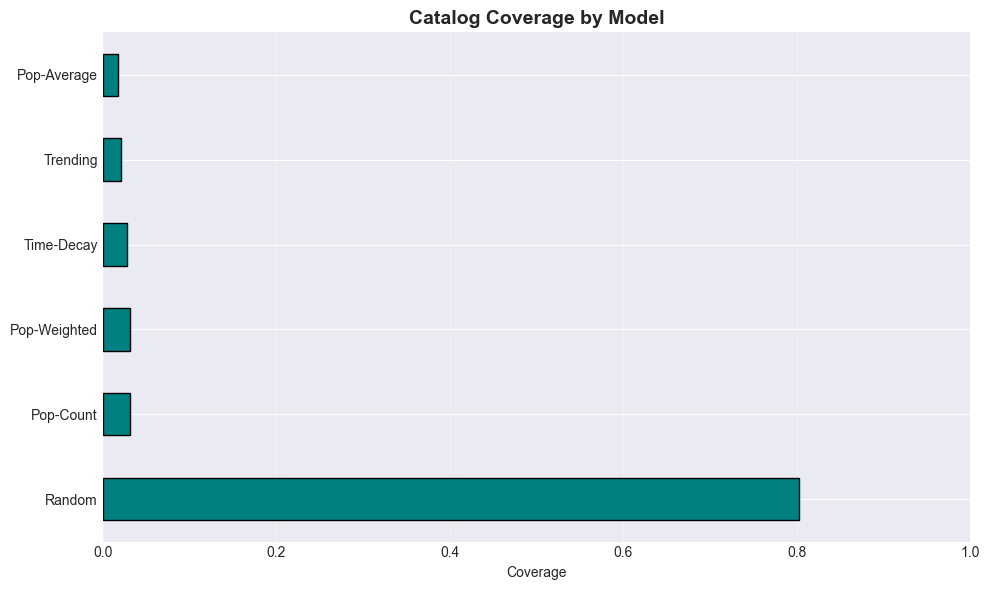

In [21]:
# ============================================================================
# 9: Analyze Coverage and Diversity
# ============================================================================
print("\n" + "="*70)
print("COVERAGE AND DIVERSITY ANALYSIS")
print("="*70)

# Coverage comparison
print("\nCatalog Coverage:")
for model_name, model in models.items():
    coverage = results_df.loc[model_name, 'Coverage']
    print(f"  {model_name:15s}: {coverage:.4f} ({coverage*len(all_items):.0f}/{len(all_items)} items)")

# Visualize coverage
plt.figure(figsize=(10, 6))
coverage_data = results_df['Coverage'].sort_values(ascending=False)
coverage_data.plot(kind='barh', color='teal', edgecolor='black')
plt.title('Catalog Coverage by Model', fontsize=14, fontweight='bold')
plt.xlabel('Coverage')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



RECOMMENDATION OVERLAP ANALYSIS

Recommendation Overlap for User 1 (Top-20):
              Random  Pop-Count  Pop-Average  Pop-Weighted  Time-Decay  \
Random          1.00       0.00          0.0          0.05        0.05   
Pop-Count       0.00       1.00          0.2          0.50        0.60   
Pop-Average     0.00       0.20          1.0          0.50        0.30   
Pop-Weighted    0.05       0.50          0.5          1.00        0.50   
Time-Decay      0.05       0.60          0.3          0.50        1.00   
Trending        0.05       0.05          0.1          0.05        0.30   

              Trending  
Random            0.05  
Pop-Count         0.05  
Pop-Average       0.10  
Pop-Weighted      0.05  
Time-Decay        0.30  
Trending          1.00  


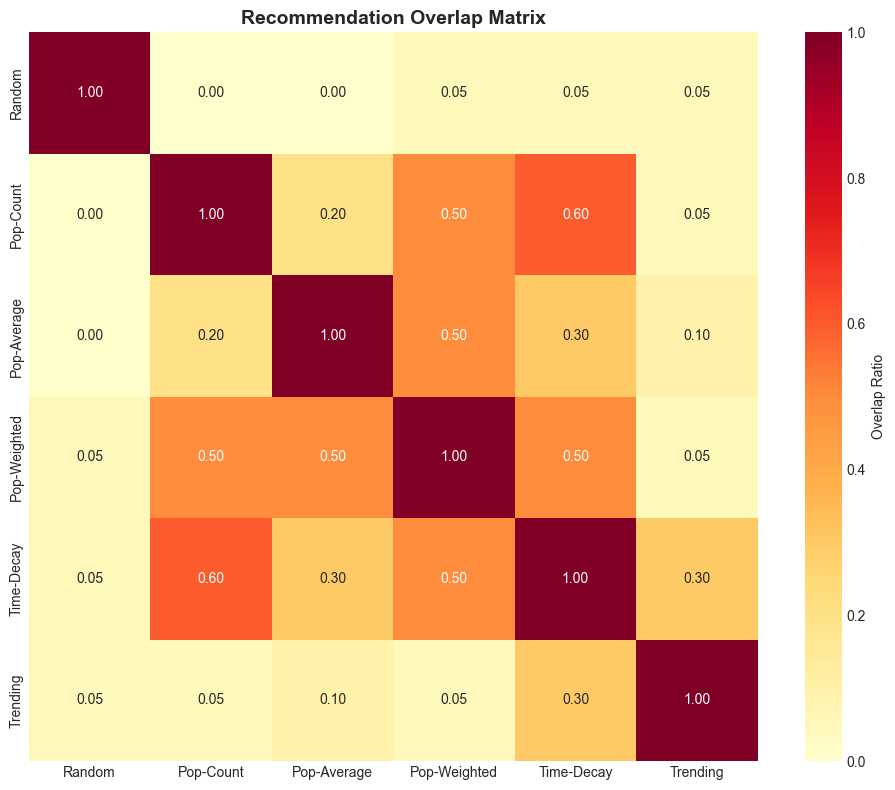

In [22]:
# ============================================================================
# 10: Recommendation Overlap Analysis
# ============================================================================
print("\n" + "="*70)
print("RECOMMENDATION OVERLAP ANALYSIS")
print("="*70)

# Get recommendations from all models for a sample user
sample_user = 1
all_recs = {}

for model_name, model in models.items():
    recs = model.recommend(user_id=sample_user, n=20, exclude_seen=True)
    all_recs[model_name] = set([item_id for item_id, _ in recs])

# Calculate overlap matrix
overlap_matrix = pd.DataFrame(
    index=models.keys(),
    columns=models.keys(),
    dtype=float
)

for model1 in models.keys():
    for model2 in models.keys():
        if model1 in all_recs and model2 in all_recs:
            overlap = len(all_recs[model1] & all_recs[model2])
            overlap_matrix.loc[model1, model2] = overlap / 20.0

print(f"\nRecommendation Overlap for User {sample_user} (Top-20):")
print(overlap_matrix)

# Visualize overlap
plt.figure(figsize=(10, 8))
sns.heatmap(
    overlap_matrix.astype(float),
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Overlap Ratio'},
    square=True
)
plt.title('Recommendation Overlap Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [23]:
# ============================================================================
# 11: Key Insights
# ============================================================================
print("\n" + "="*70)
print("KEY INSIGHTS FROM BASELINE MODELS")
print("="*70)

best_precision = results_df['Precision@10'].idxmax()
best_recall = results_df['Recall@10'].idxmax()
best_ndcg = results_df['NDCG@10'].idxmax()
best_coverage = results_df['Coverage'].idxmax()
best_rmse = results_df['RMSE'].idxmin()

insights = f"""
🎯 PERFORMANCE SUMMARY:
   • Best Precision@10: {best_precision} ({results_df.loc[best_precision, 'Precision@10']:.4f})
   • Best Recall@10: {best_recall} ({results_df.loc[best_recall, 'Recall@10']:.4f})
   • Best NDCG@10: {best_ndcg} ({results_df.loc[best_ndcg, 'NDCG@10']:.4f})
   • Best Coverage: {best_coverage} ({results_df.loc[best_coverage, 'Coverage']:.4f})
   • Best RMSE: {best_rmse} ({results_df.loc[best_rmse, 'RMSE']:.4f})

💡 OBSERVATIONS:
   • Random baseline performs poorly (as expected)
   • Popularity-based methods show reasonable performance
   • Weighted popularity balances count and quality
   • Time-decay and trending capture temporal dynamics
   • All baselines have similar RMSE (predicting average)

⚠️ LIMITATIONS:
   • All baselines recommend same items to all users (no personalization)
   • High coverage but low precision/recall
   • Cannot capture user-specific preferences
   • Suffer from popularity bias

🚀 NEXT STEPS:
   • Implement collaborative filtering for personalization
   • Try content-based methods for cold-start items
   • Combine approaches in hybrid models
"""

print(insights)



KEY INSIGHTS FROM BASELINE MODELS

🎯 PERFORMANCE SUMMARY:
   • Best Precision@10: Pop-Weighted (0.1293)
   • Best Recall@10: Pop-Count (0.1381)
   • Best NDCG@10: Pop-Count (0.1685)
   • Best Coverage: Random (0.8020)
   • Best RMSE: Random (1.2263)

💡 OBSERVATIONS:
   • Random baseline performs poorly (as expected)
   • Popularity-based methods show reasonable performance
   • Weighted popularity balances count and quality
   • Time-decay and trending capture temporal dynamics
   • All baselines have similar RMSE (predicting average)

⚠️ LIMITATIONS:
   • All baselines recommend same items to all users (no personalization)
   • High coverage but low precision/recall
   • Cannot capture user-specific preferences
   • Suffer from popularity bias

🚀 NEXT STEPS:
   • Implement collaborative filtering for personalization
   • Try content-based methods for cold-start items
   • Combine approaches in hybrid models



In [24]:
# ============================================================================
# 12: Save Results
# ============================================================================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save evaluation results
results_df.to_csv('../data/processed/baseline_results.csv')
print("✓ Results saved to data/processed/baseline_results.csv")

# Save best models
import pickle
os.makedirs('../models', exist_ok=True)

pop_weighted.save('../models/popularity_weighted.pkl')
time_decay_rec.save('../models/time_decay.pkl')

print("✓ Best models saved to models/")
print("\n✅ Baseline evaluation complete!")


SAVING RESULTS
✓ Results saved to data/processed/baseline_results.csv
Model saved to ../models/popularity_weighted.pkl
Model saved to ../models/time_decay.pkl
✓ Best models saved to models/

✅ Baseline evaluation complete!
